<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модели" data-toc-modified-id="Модели-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Важность-прзнаков" data-toc-modified-id="Важность-прзнаков-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Важность прзнаков</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [39]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import numpy as np

загрузка библиотек

In [3]:
# Загрузка данных

df=pd.read_csv('/datasets/taxi.csv',parse_dates=[0], index_col=[0])

#просмотр 5 рандомных строк

df.sample(5)

,num_orders
datetime,
2018-05-01 05:50:00,0
2018-03-08 07:00:00,4
2018-07-20 22:40:00,22
2018-04-27 23:30:00,13
2018-05-03 14:20:00,11


In [4]:
# общая инфорация

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [6]:
df=df.resample('1H').sum()

### Вывод

- Библиотеки импортированы

- Данные загружены,проиндексированы

- Пропуски отсутвуют

- Произведено ресемплирование по 1 часу

## Анализ

Для более адекватного анализа разобъём времянной ряд на тренды  и сеззоность а так хе применим к нему скользящее среднее

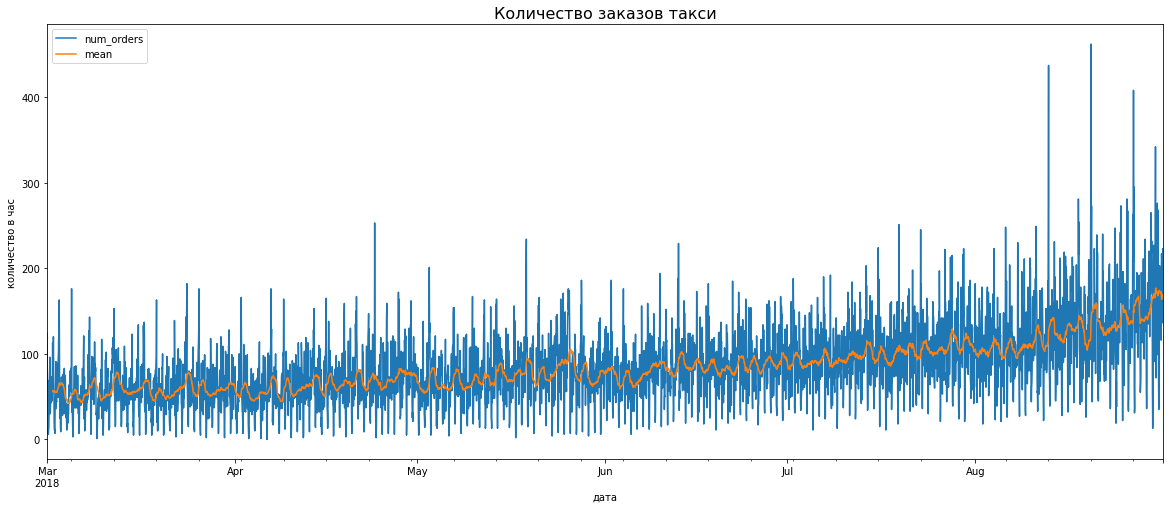

In [7]:
# скользящее среднее
df['mean'] = df['num_orders'].rolling(24).mean()
ax = df.plot(figsize=(20, 8))
ax.set_title('Количество заказов такси', fontsize=16)
ax.set(ylabel='количество в час', xlabel='дата');

Исходя из данного графика сложно что либо говорить,произведем ресспемлирование по дням

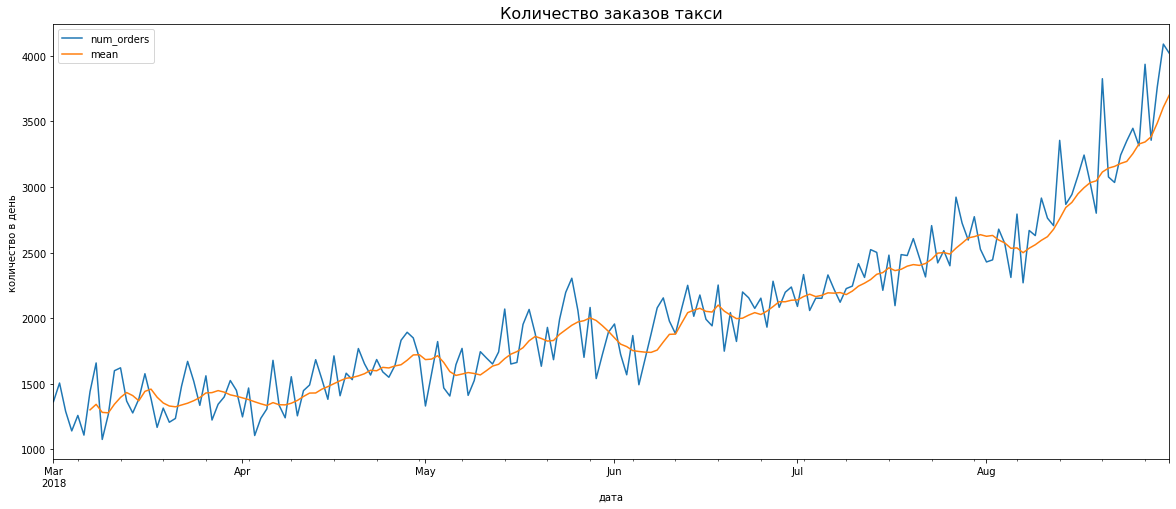

In [8]:
df_day = df.resample('1d').sum()
df_day['mean'] = df_day['num_orders'].rolling(7).mean()

ax = df_day.plot(figsize=(20, 8))
ax.set_title('Количество заказов такси', fontsize=16)
ax.set(ylabel='количество в день', xlabel='дата');

По графику видно,что обозримом приоде количество средних заказов такси только росло

Произвидем декомпозицию данных о заказ на тренд сезонст и остаток


In [9]:
decomposed = seasonal_decompose(df['num_orders'].resample('1d').sum())

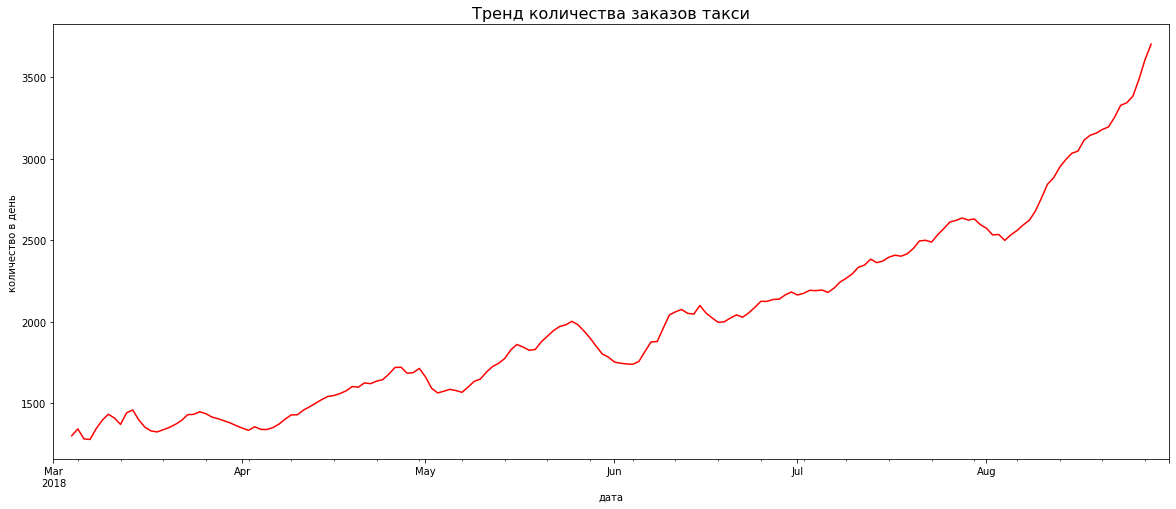

In [10]:
ax = decomposed.trend.plot(figsize=(20, 8), color='r')
ax.set_title('Тренд количества заказов такси', fontsize=16)
ax.set(ylabel='количество в день', xlabel='дата');

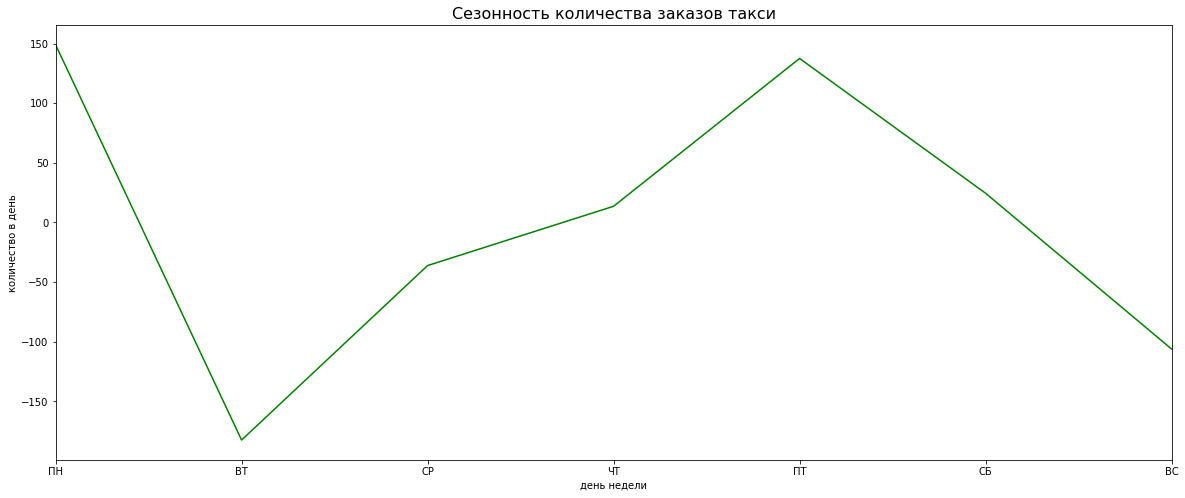

In [11]:
ax = decomposed.seasonal['2018-03-05 00:00:00':'2018-03-11 00:00:00'].plot(figsize=(20, 8), color='g')
ax.set_title('Сезонность количества заказов такси', fontsize=16)
ax.set(ylabel='количество в день', xlabel='день недели');
plt.xticks(decomposed.seasonal['2018-03-05 00:00:00':'2018-03-11 00:00:00'].index, ['ПН','ВТ','СР','ЧТ','ПТ','СБ','ВС']);

STD заказов такси в день: 123.28196551996496


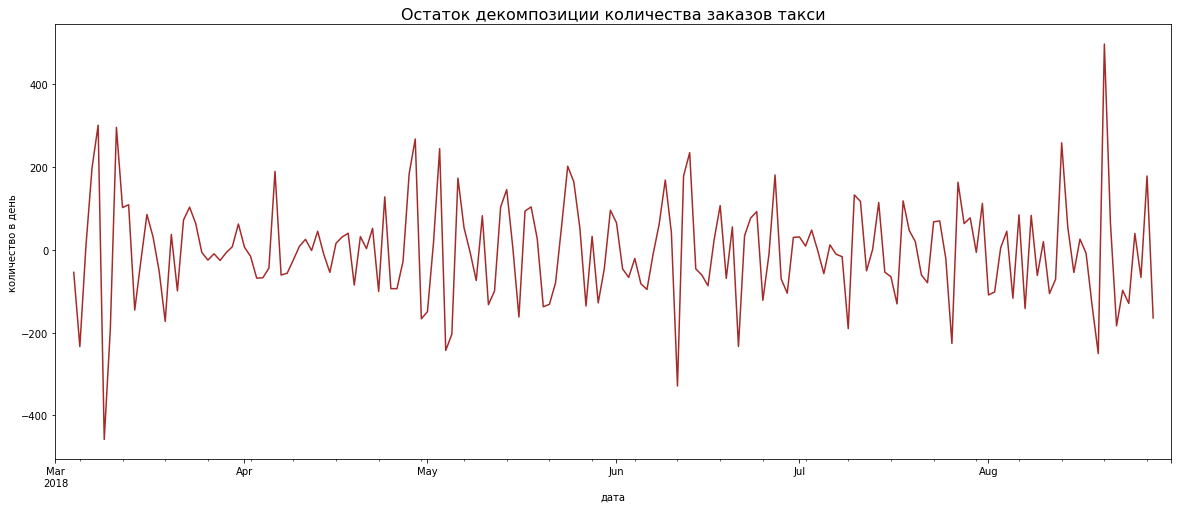

In [12]:
ax = decomposed.resid.plot(figsize=(20, 8), color='brown')
ax.set_title('Остаток декомпозиции количества заказов такси', fontsize=16)
ax.set(ylabel='количество в день', xlabel='дата');
print('STD заказов такси в день:', decomposed.resid.std())

Заглянем поглубже,рассмотрим на примере одной недели

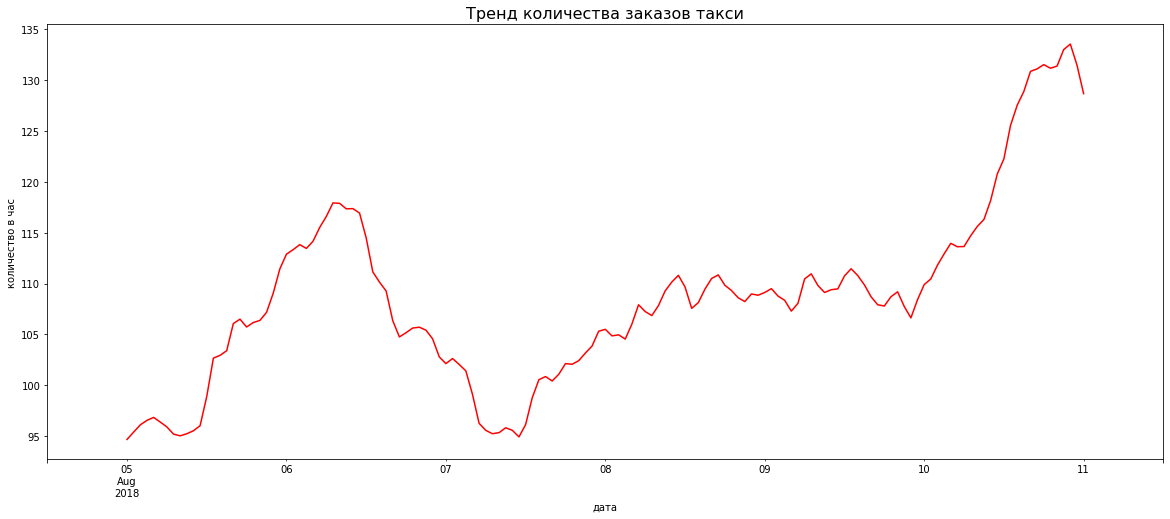

In [13]:
decomposed_week = seasonal_decompose(df.loc['2018-08-04 12:00:00':'2018-08-11 12:00:00', 'num_orders'])
ax = decomposed_week.trend.plot(figsize=(20, 8), color='r')
ax.set_title('Тренд количества заказов такси', fontsize=16)
ax.set(ylabel='количество в час', xlabel='дата');

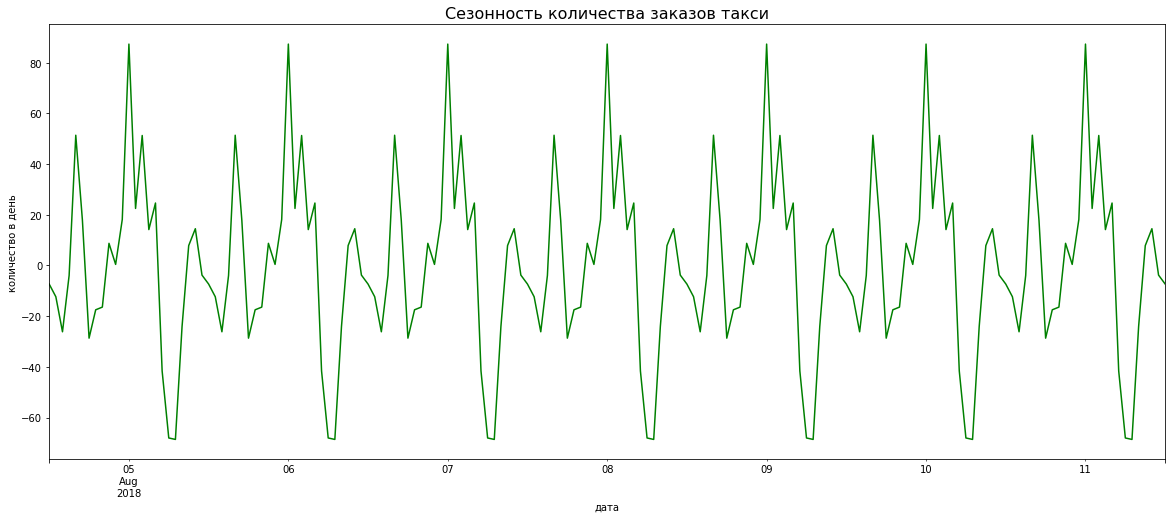

In [14]:
ax = decomposed_week.seasonal.plot(figsize=(20, 8), color='g')
ax.set_title('Сезонность количества заказов такси', fontsize=16)
ax.set(ylabel='количество в день', xlabel='дата');

Стандартное отклонение количества заказов такси в час: 23.318004063287837


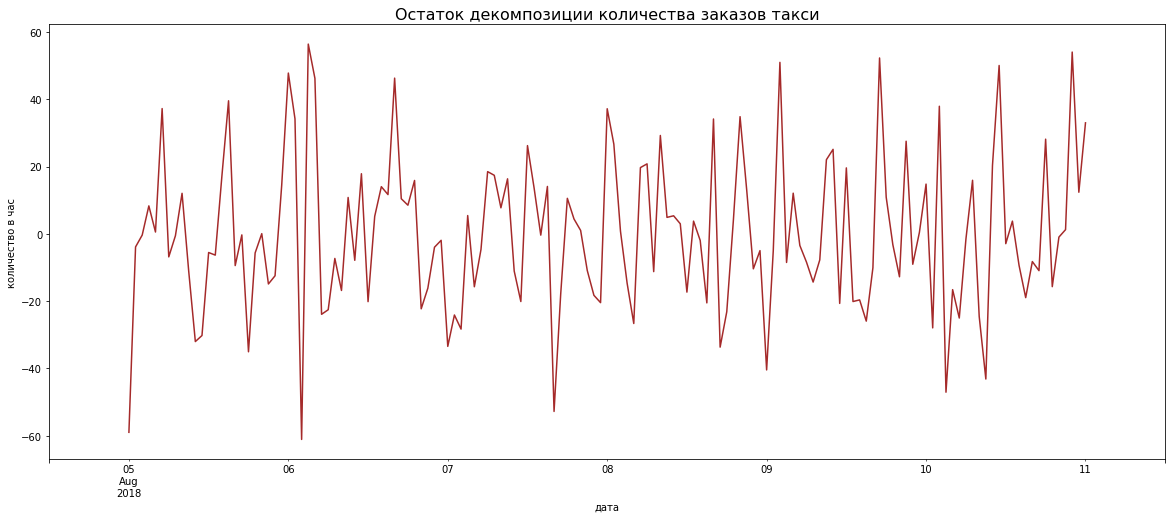

In [15]:
ax = decomposed_week.resid.plot(figsize=(20, 8), color='brown')
ax.set_title('Остаток декомпозиции количества заказов такси', fontsize=16)
ax.set(ylabel='количество в час', xlabel='дата');
print('Стандартное отклонение количества заказов такси в час:', decomposed_week.resid.std())

### Вывод

При анализе времянног ряда наблюдаем следующие выводы

- Наблюдается восходящий тренд,в среднем заказы такси растут ежемесячно

- Внутри недели присутвуют колебания заказов такс +- 150 закзов  в зависимости от дня недели

- В остатке наблюдаем +-400 заказов,с колебанием в 120 едениц

## Обучение

План по обучению будет таким

Для начала подготовим признаки

Далее создадим выборки

- Тренировочную

- Валидационную 

- Тестувую

Затем обучим модели

In [16]:
# Подготовка признаков

def make_features(data, max_lag, rolling_mean_size):
    data = pd.DataFrame(data)
    # Создание признаков
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    # Создание сдвигов
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # Создание скользящего среднего
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

# Вызов функции создания признаков
df_learn = make_features(df['num_orders'], 24, 30)

Признаки подгатовлены,путем перебора определено что лучшие показатели для макс значение сдвига 24ч и скользящее среднее 30

In [17]:
# Подготовка выборок

#тренировочная 80% и тестовая 20%
train, test = train_test_split(df_learn,
                               shuffle=False, 
                               test_size=0.2, 
                               random_state=12345
                              )
# Пропуски при создании
train = train.dropna()

# Определение признаков
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# Деление валидационной и тестовой 
features_valid, features_test, target_valid, target_test = train_test_split(features_test, 
                                                                            target_test, 
                                                                            shuffle=False,
                                                                            test_size=0.5, 
                                                                            random_state=12345
                                                                           )


In [18]:
print('Тренировочная:',features_train.shape[0], target_train.shape[0])
print('Валидационная:',features_valid.shape[0], target_valid.shape[0])
print('Тестовая:',features_test.shape[0],  target_test.shape[0])

Тренировочная: 3502 3502
Валидационная: 442 442
Тестовая: 442 442


Выборки готовы к обучению

### Модели

In [19]:
def get_rmse_valid(model, X=features_train, y=target_train, X_test=features_valid, y_test=target_valid):
    model.fit(X, y)
    predictions = model.predict(X_test)

    # Отображение предсказаний
    ax = pd.DataFrame(data = {'Истинные':y_test, 'Прогнозируемые':predictions}).plot(figsize=(20, 8))
    ax.set_title('Количество заказов такси', fontsize=16)
    ax.set(ylabel='количество в час', xlabel='дата')
    
    return round(mean_squared_error(y_test, predictions, squared=False), 1)

In [20]:
def get_rmse_cv(model, parametrs, X=features_train.append(features_valid), y=target_train.append(target_valid)):
    rs = RandomizedSearchCV(model, 
                            parametrs, 
                            scoring='neg_root_mean_squared_error', 
                            cv=TimeSeriesSplit(n_splits=5).split(X),
                            random_state = 123
                           )
    rs.fit(X, y)
    
    return round(rs.best_score_), rs.best_params_

**Линейная регрессия**

33.9

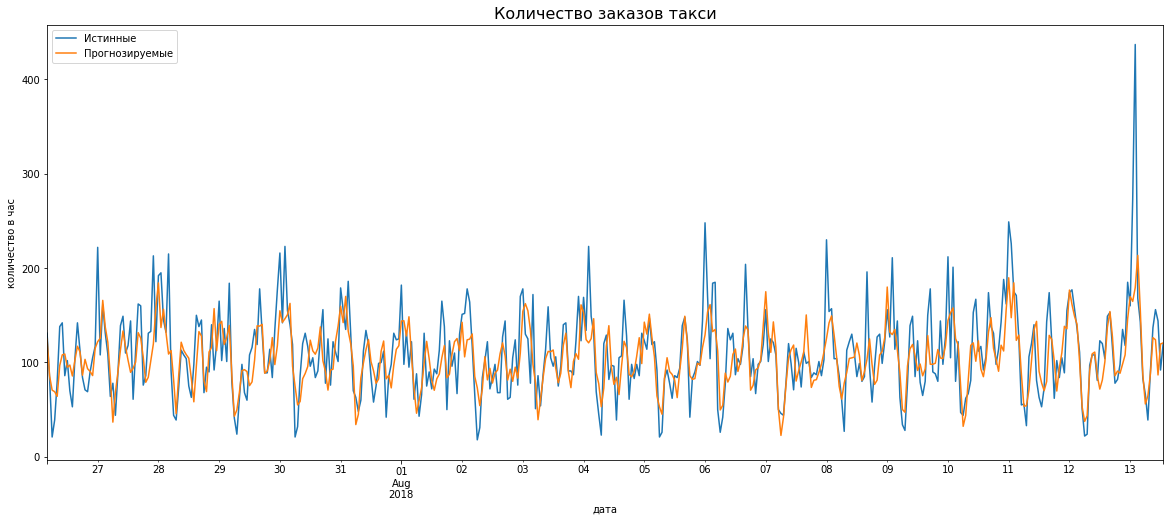

In [21]:
get_rmse_valid(LinearRegression())

**Дерево решений**

CPU times: user 89.4 ms, sys: 3.64 ms, total: 93.1 ms
Wall time: 98.1 ms


39.4

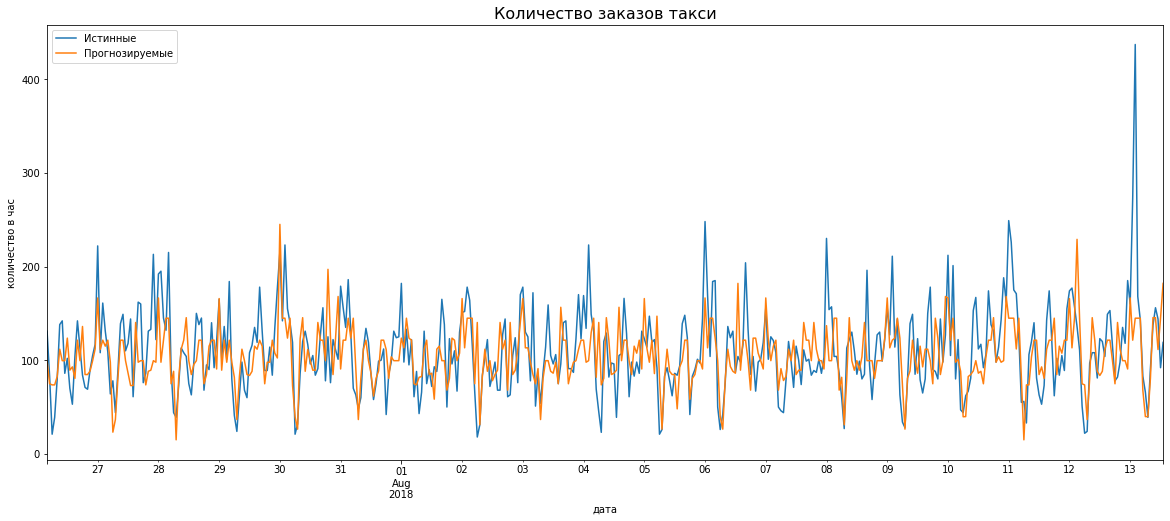

In [22]:
%%time
get_rmse_valid(DecisionTreeRegressor(max_depth=8, random_state=123))

In [23]:
# Подбор гипперпараметров

get_rmse_cv(DecisionTreeRegressor(random_state=123), { 'max_depth':range(5,50)})

(-31, {'max_depth': 6})

**CatBoost**

32.3

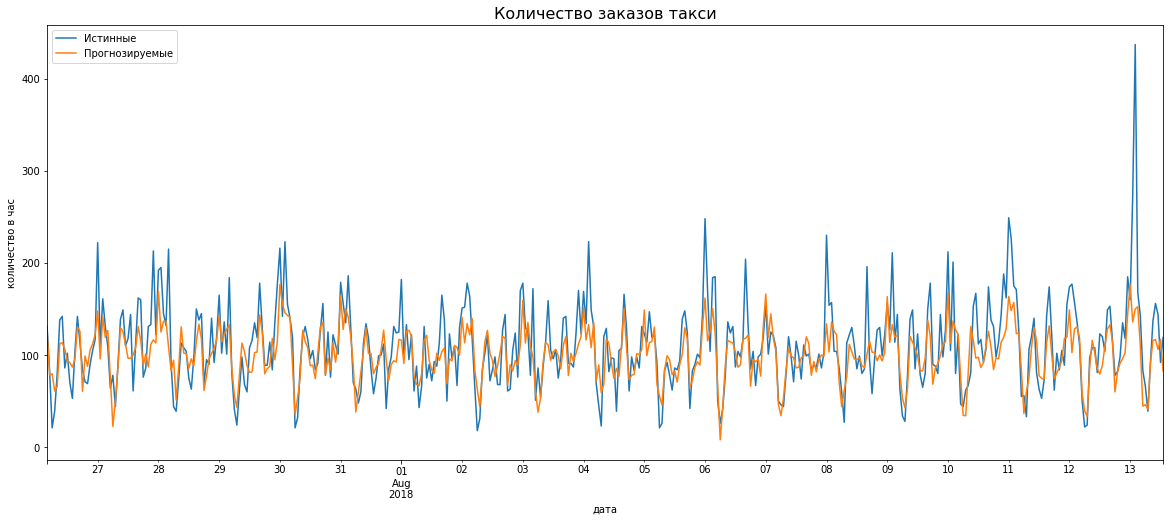

In [24]:
get_rmse_valid(CatBoostRegressor(silent=True, random_state=123))

In [25]:
# подбор гипперпараметров
get_rmse_cv(CatBoostRegressor(silent=True, random_state=123), 
            { 'l2_leaf_reg': range(1,10),
              'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 1],
               'depth' : range(1,10)
            })

(-25, {'learning_rate': 0.08, 'l2_leaf_reg': 3, 'depth': 5})

32.5

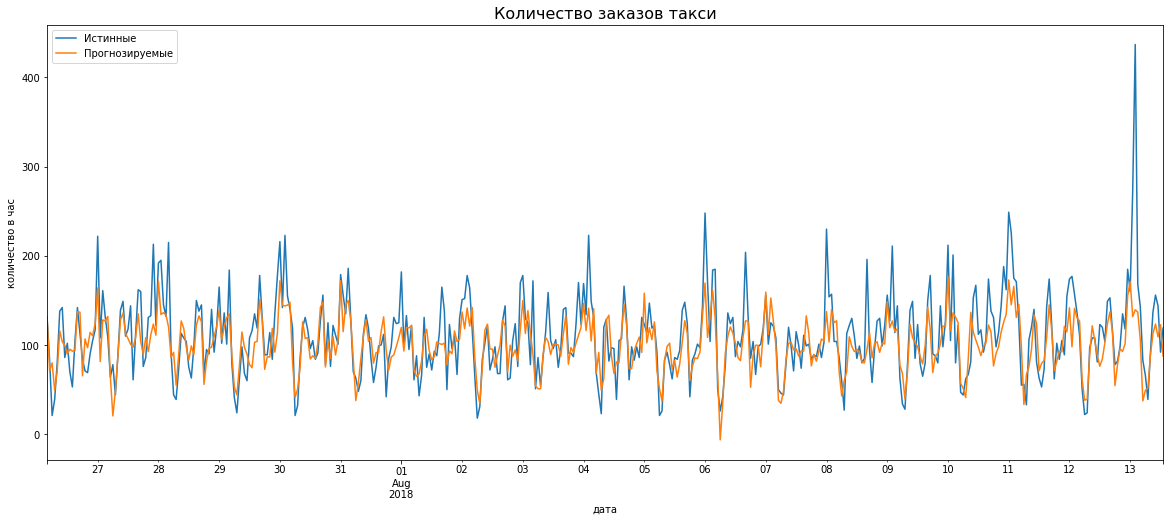

In [26]:
get_rmse_valid(CatBoostRegressor(learning_rate=0.08, l2_leaf_reg=3, depth=5, silent=True, random_state=123))

### Вывод

На данном этапе были проведены следующие действия

- Созданы и подгатовлены признаки

- Разделены данные на выборки

- Рассмотрены и обучены несколько моделей и с подбором гипперпараметров

Лучшая модель с наименьшим RMSE оказалась catboost

## Тестирование

Тестирование модели на тестовой выборке

41.4

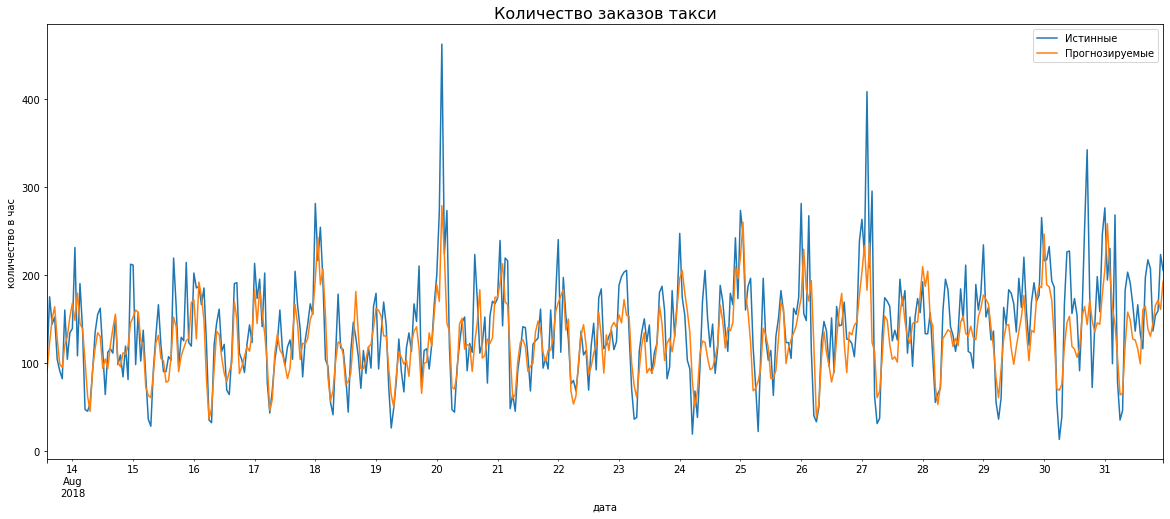

In [28]:
get_rmse_valid(CatBoostRegressor(silent=True, random_state=123),
               X=features_train.append(features_valid),
               y=target_train.append(target_valid),
               X_test=features_test,
               y_test=target_test
              )

На тестовой выборке модель показала результат несколько хуже

### Проверка на адекватность

Расчет rmse для константной модели

In [40]:
print('RMSE:', mean_squared_error(target_test, (np.ones(target_test.shape[0]) * target_test.median()), squared=False))

RMSE: 58.7266464607412


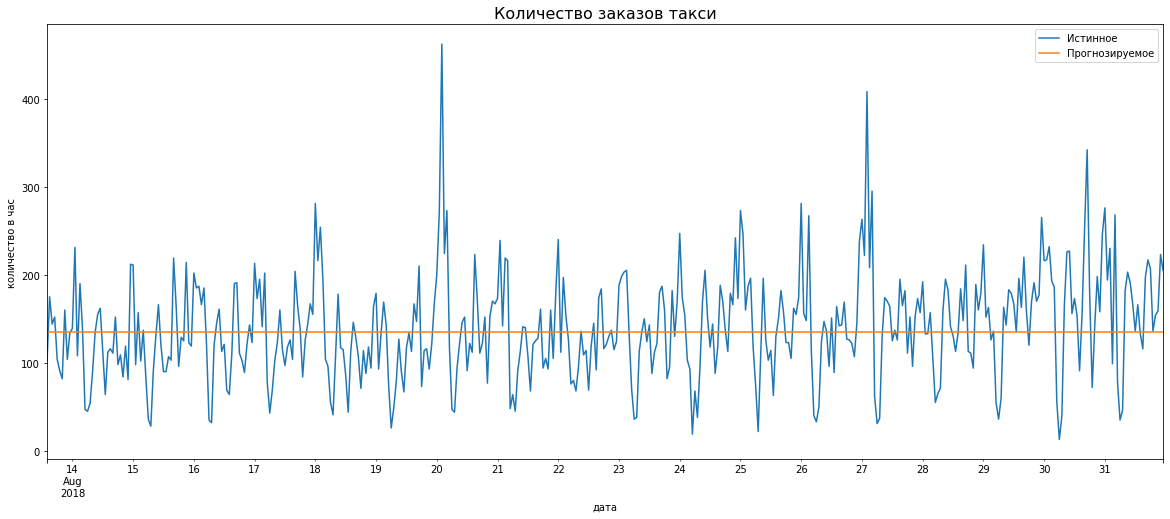

In [49]:
# Конастантная модель

ax = pd.DataFrame(data={'Истинное':target_test, 'Прогнозируемое':(
    np.ones(target_test.shape[0])*target_test.median())}).plot(figsize=(20, 8))
ax.set_title('Количество заказов такси', fontsize=16)
ax.set(ylabel='количество в час', xlabel='дата');

In [55]:
# Модель прогнозирующая по предыдущенму шагу
pred_previous = target_test.shift(fill_value=target_train.iloc[-1])
print('RMSE:', mean_squared_error(target_test, pred_previous, squared=False))

RMSE: 58.88016052260236


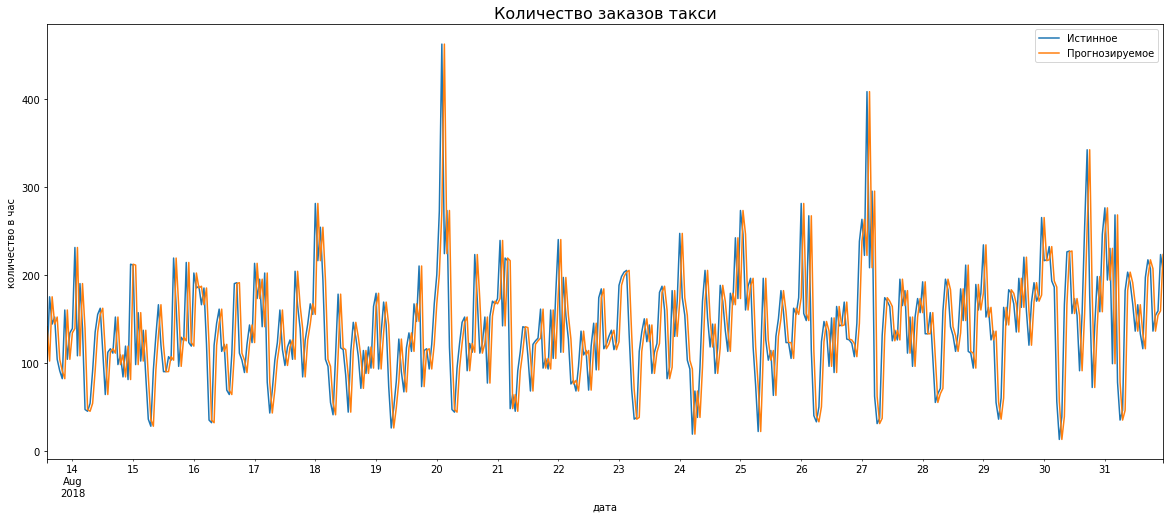

In [56]:
ax = pd.DataFrame(data = {'Истинное':target_test, 'Прогнозируемое':pred_previous}).plot(figsize=(20, 8))
ax.set_title('Количество заказов такси', fontsize=16)
ax.set(ylabel='количество в час', xlabel='дата');

Константная модель и модель прогнозирующая по предыдущему шагу показывают результат хуже чем наша

### Важность прзнаков

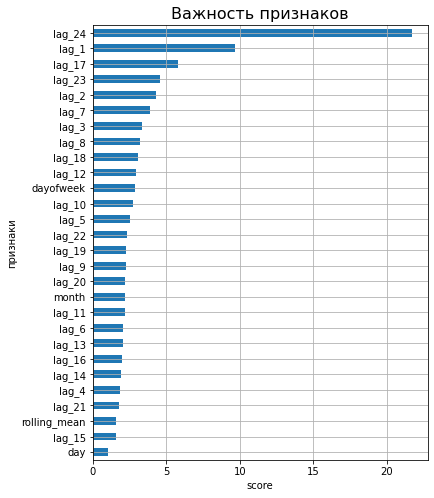

In [58]:
model = CatBoostRegressor(silent=True, random_state=123)

# Обучение модели
model.fit(features_train, target_train)
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': model.feature_importances_}, 
                            index=features_train.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(6,8), legend=False);
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

Видно 2 самых важных признака

- Сдвиг на 24 часа

- Сдвиг на 1 час

## Вывод

На этапе подготовки данных 

- Библиотеки импортированы

- Данные загружены,проиндексированы

- Пропуски отсутвуют

- Произведено ресемплирование по 1 часу

На этапе анализа данных 

- Наблюдается восходящий тренд,в среднем заказы такси растут ежемесячно

- Внутри недели присутвуют колебания заказов такс +- 150 закзов  в зависимости от дня недели

- В остатке наблюдаем +-400 заказов,с колебанием в 120 едениц

На этапе обучения модели

- Созданы и подгатовлены признаки

- Разделены данные на выборки

- Рассмотрены и обучены несколько моделей и с подбором гипперпараметров

Лучшая модель с наименьшим RMSE оказалась catboost

На этапе тестирования модели

- Была протестирована лучшая модель  CatBoost с резульаттом 41.4

- Данная модель прошла проверку на адекватность

- А так же определена важность признаков

Задача поставленная заказчиком выполнена,рекомендую использовать модель CatBoost

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48